In [1]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

from umap.umap_ import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS

code_id = "0860 - 2 - Retrieval on Session-Basis"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

saved_dir = join(loc, "Retrieval Results")
dir_name = join(figpath, "Dsp", "Reforming Neural Trajectory Analysis") 
mkdir(saved_dir)
pass

        E:\Data\FinalResults\Dsp\0860 - 2 - Retrieval on Session-Basis is already existed!
        E:\Data\FinalResults\Dsp\0860 - 2 - Retrieval on Session-Basis\Retrieval Results is already existed!


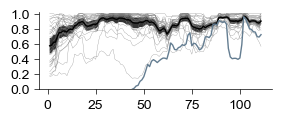

In [ ]:
def hidden_state_proportion(
    mouse: int,
    rt: int = 0
):
    if exists(join(saved_dir, f"{mouse}_behav_R{rt+1}.pkl")):
        with open(join(saved_dir, f"{mouse}_behav_R{rt+1}.pkl"), 'rb') as f:
            return pickle.load(f)
    else:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
            
        hidden_state_traj = res['raw_hidden_state_traj']
        session_traj = res['raw_session_traj']
        route_traj = res['raw_route_traj']
        nodes_traj = res['raw_nodes_traj']
        father_nodes_traj = S2F[nodes_traj-1]
        lap_traj = res['raw_lap_traj']
        time_traj = res['raw_time_traj']
        dt = np.zeros_like(time_traj, np.float64)
        
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]))
        for i in range(len(beg)):
            dt[beg[i]:end[i]] = np.diff(time_traj[beg[i]:end[i]], prepend=time_traj[beg[i]])
        
        if rt == 0:
            state_sum = np.zeros((144, 7*4))
            time_sum = np.zeros((144, 7*4))
            for s in range(7):
                n_lap = np.unique(lap_traj[(route_traj == 0) & (session_traj == s)])
                
                division = np.concatenate([np.arange(0, n_lap.shape[0], int(n_lap.shape[0]/4)+1), [n_lap.shape[0]]])
                for i in range(division.shape[0]-1):
                    for b in CP_DSP[0]:
                        idx = np.where(
                            (np.isin(lap_traj, n_lap[division[i]:division[i+1]])) &
                            (session_traj == s) &
                            (route_traj == 0) & 
                            (father_nodes_traj == b)
                        )[0]
                        
                        if idx.shape[0] < 1:
                            continue                
                    
                        state_sum[b-1, s*4 + i] = np.sum((1-hidden_state_traj[idx]) * dt[idx])
                        time_sum[b-1, s*4 + i] = np.sum(dt[idx])
            
            prop = np.zeros((144, 7*4))
            for j in range(prop.shape[1]):
                prop[CP_DSP[0]-1, j] = (
                    np.convolve(state_sum[CP_DSP[0]-1, j], np.ones(7), mode='same') /
                    np.convolve(time_sum[CP_DSP[0]-1, j], np.ones(7), mode='same')
                )
            
            with open(join(saved_dir, f"{mouse}_behav_R{rt+1}.pkl"), 'wb') as f:
                pickle.dump(prop, f)
            
            return prop
        else:
            state_sum = np.zeros((144, 7))
            time_sum = np.zeros((144, 7))
            for s in range(7):
                for b in CP_DSP[rt]:
                    idx = np.where(
                        (route_traj == rt) &
                        (session_traj == s) & 
                        (father_nodes_traj == b)
                    )[0]
                    
                    if idx.shape[0] < 1:
                        continue
                    
                    state_sum[b-1, s] = np.sum((1-hidden_state_traj[idx]) * dt[idx])
                    time_sum[b-1, s] = np.sum(dt[idx])
                    
            prop = np.zeros((144, 7))
            for j in range(prop.shape[1]):
                prop[CP_DSP[rt]-1, j] = (
                    np.convolve(state_sum[CP_DSP[rt]-1, j], np.ones(7), mode='same') /
                    np.convolve(time_sum[CP_DSP[rt]-1, j], np.ones(7), mode='same')
                )
                
            if rt == 3:
                prop *= np.nan
            if rt == 6:
                convert_session = np.where(session_convertor[mouse] >= 0)[0][0]
                prop[:, convert_session:] = np.nan
                
            with open(join(saved_dir, f"{mouse}_behav_R{rt+1}.pkl"), 'wb') as f:
                pickle.dump(prop, f)
            return prop

for mouse in [10212, 10224, 10227, 10232]:
    for r in range(7):
        hidden_state_proportion(mouse, r)
prop_r0 = hidden_state_proportion(10232, 0)
sem = scipy.stats.sem(prop_r0[CP_DSP[0]-1, :], axis=1)  # standard error of the mean
n = prop_r0.shape[1]

# 95% confidence interval (using t-distribution)
confidence = 0.95
h = sem * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
top_line = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1) + h
bottom_line = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1) - h

prop_r5 = hidden_state_proportion(10232, 5)

fig = plt.figure(figsize=(3, 1))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
for i in range(prop_r0.shape[1]):
    ax.plot(
        np.arange(1, 112),
        prop_r0[CP_DSP[0]-1, i],
        color='grey',
        lw=0.2
    )
ax.plot(
    np.arange(1, 112),
    np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1),
    color='k',
    lw=1
),
ax.fill_between(
    np.arange(1, 112),
    top_line,
    bottom_line,
    color='k',
    edgecolor=None,
    alpha=0.8
)
ax.plot(
    np.arange(1, 112)[-CP_DSP[5].shape[0]:],
    prop_r5[CP_DSP[5]-1, 0],
    color=DSPPalette[5],
    lw=1
)
ax.set_ylim(0, 1.02)
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(join(loc, "Hidden State Retrieval [Example].png"), dpi=600)
plt.savefig(join(loc, "Hidden State Retrieval [Example].svg"), dpi=600)
plt.show()


In [ ]:
def get_session_wise_neural_retrieval(mouse: int, rt: int = 0):
    if exists(join(saved_dir, f"{mouse}_neural_R{rt+1}.pkl")):
        with open(join(saved_dir, f"{mouse}_neural_R{rt+1}.pkl"), 'rb') as f:
            corr = pickle.load(f)

        for i in range(corr.shape[1]):
            corr[CP_DSP[rt]-1, i] = np.nan_to_num(corr[CP_DSP[rt]-1, i], nan=0)
            corr[CP_DSP[rt]-1, i] = np.convolve(
                corr[CP_DSP[rt]-1, i], np.ones(7)/7, mode='same'
            )
        return corr
    else:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        print(f"{mouse} R{rt+1}")
        if rt == 0:
            corr = np.zeros((144, 7*4))
            for s in tqdm(range(7)):
                with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                    trace = pickle.load(f)
            
                r0_map_avg = np.mean(np.stack([
                    trace[f'node {n}']['old_map_clear'] for n in [0, 4, 5, 9]
                ], axis=2), axis=2)
            
                for i, n in enumerate([0, 4, 5, 9]):
                    r0_map = trace[f'node {n}']['old_map_clear']
                    for b in CP_DSP[0]:
                        corr[b-1, s*4 + i] = np.corrcoef(
                            r0_map[:, b-1], r0_map_avg[:, b-1]
                        )[0, 1]
            
        else:
            corr = np.zeros((144, 7))
            for s in tqdm(range(7)):
                with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                    trace = pickle.load(f)

                r0_map_avg = np.mean(np.stack([
                    trace[f'node {n}']['old_map_clear'] for n in [0, 4, 5, 9]
                ], axis=2), axis=2)

                nodes_convertor = np.array([0, 1, 2, 3, 6, 7, 8])
                for i, b in enumerate(CP_DSP[rt]):
                    rt_map = trace[f'node {nodes_convertor[rt]}']['old_map_clear']
                    corr[b-1, s] = np.corrcoef(
                        rt_map[:, b-1], r0_map_avg[:, b-1]
                    )[0, 1]
                
        with open(join(saved_dir, f"{mouse}_neural_R{rt+1}.pkl"), 'wb') as f:
            pickle.dump(corr, f)
    
        for i in range(corr.shape[1]):
            corr[CP_DSP[rt]-1, i] = np.nan_to_num(corr[CP_DSP[rt]-1, i], nan=0)
            corr[CP_DSP[rt]-1, i] = np.convolve(
                corr[CP_DSP[rt]-1, i], np.ones(7)/7, mode='same'
            ) 
        return corr

for mouse in [10232]:
    for r in range(3, 7):
        get_session_wise_neural_retrieval(mouse, r)

corr_r0 = get_session_wise_neural_retrieval(10232, 0)
sem = scipy.stats.sem(corr_r0[CP_DSP[0]-1, :], axis=1)  # standard error of the mean
n = corr_r0.shape[1]

# 95% confidence interval (using t-distribution)
confidence = 0.95
h = sem * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
top_line = np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1) + h
bottom_line = np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1) - h
print(np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1))

corr_r5 = get_session_wise_neural_retrieval(10232, 5)

fig = plt.figure(figsize=(3, 1))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
for i in range(corr_r0.shape[1]):
    ax.plot(
        np.arange(1, 112),
        corr_r0[CP_DSP[0]-1, i],
        color='grey',
        lw=0.2
    )
"""
ax.plot(
    np.arange(1, 112),
    np.nanmean(corr_r0[CP_DSP[0]-1, :], axis=1),
    color='k',
    lw=1
),
ax.fill_between(
    np.arange(1, 112),
    top_line,
    bottom_line,
    color='k',
    edgecolor=None,
    alpha=0.8
)
"""
ax.plot(
    np.arange(1, 112)[-CP_DSP[5].shape[0]:],
    corr_r5[CP_DSP[5]-1, 0],
    color=DSPPalette[5],
    lw=1
)
ax.set_ylim(0, 1.02)
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(join(loc, "Neuronal Retrieval [Example].png"), dpi=600)
plt.savefig(join(loc, "Neuronal Retrieval [Example].svg"), dpi=600)
plt.show()

10232 R4


 14%|█▍        | 1/7 [00:04<00:25,  4.32s/it]